<a href="https://colab.research.google.com/github/TsvetaIvanova/ColabIMLO/blob/main/OffIMLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running instructions

In [ ]:
!pip install torchviz

## imports

In [ ]:
import pandas as pd
from sklearn import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, transforms
import time
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from google.colab import runtime
from google.colab import drive
from torchsummary import summary
from torchviz import make_dot
from torchvision.transforms import v2



#Get full dataset into dataframe


In [ ]:
print(torch.__version__)
# !pip install torch==2.2.2

2.3.0+cu121


# Get and process data


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:

data_train_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(50),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


data_val_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


data_test_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
def show_image(dataset, index=0):
    image, label = dataset[index]
    image = (image * torch.tensor([0.229, 0.224, 0.225])[:, None, None]) + torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    image = image.clamp(0, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f'Label: {label}')
    plt.show()



In [ ]:
train_set = datasets.Flowers102(root='data', split='train', download=True, transform=data_train_transform)
test_set = datasets.Flowers102(root='data', split='test', download=True, transform=data_test_transform)
val_set = datasets.Flowers102(root='data', split='val', download=True, transform=data_val_transform)


# creating data loaders

train_loader = DataLoader(dataset=train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset=val_set, batch_size=16, shuffle=False)


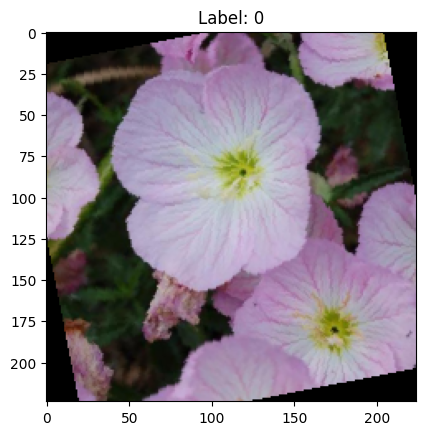

In [ ]:
show_image(train_set)

## using the datasets.Flowers102 function

# preprocess data for training


# Test

# NN Architecture(Neural Network)


## define the model

In [ ]:
#a second dropout to the best performing one 52.6%

class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 102)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        #print(x.shape)
        x = x.view(-1, 512 * 14 * 14)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x



In [ ]:
  # Training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch % 10 == 0:
            print(f'Epoch {t+1}, Batch {batch}, Loss: {loss.item():.4f}')
        if batch == 0:
            start_time = time.time()
        elif batch == 1:
            elapsed_time = time.time() - start_time
            print(f"Time per batch: {elapsed_time:.2f} seconds")

    average_loss = total_loss / len(dataloader)
    print(f'Average Loss: {average_loss:.4f}')


In [ ]:
# Testing function
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss  # Ensure this value is returned


In [ ]:
model = ConvNN().to(device)
summary(model, (3, 224, 224))
print(model)
model.eval()
x = torch.randn(1, 3, 224, 224).to(device)
y = model(x)
dot = make_dot(y, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('model_architecture')

# LossFN
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)  # Added L2 regularization


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
       BatchNorm2d-5        [-1, 128, 112, 112]             256
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
       BatchNorm2d-8          [-1, 256, 56, 56]             512
         MaxPool2d-9          [-1, 256, 28, 28]               0
           Conv2d-10          [-1, 512, 28, 28]       1,180,160
      BatchNorm2d-11          [-1, 512, 28, 28]           1,024
        MaxPool2d-12          [-1, 512, 14, 14]               0
           Linear-13                 [-1, 1024]     102,761,472
      BatchNorm1d-14                 [-

# Train and Evaluation


In [ ]:
# Training and evaluation loop
epochs = 400
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs},\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    if t >= 19:
      val_loss = test(val_loader, model, loss_fn)
      scheduler.step(val_loss)

    # Checkpointing every 100 epochs
    if t % 100 == 0 and t != 0:
        torch.save(model.state_dict(), f'model_epoch_{t}.pth')
        print(f'Checkpoint saved at epoch {t}')

print("This marks the end of training the model, now commences the eval stage on the test data")


Epoch 1/400,
-------------------------------
Epoch 1, Batch 0, Loss: 5.1025
Time per batch: 0.20 seconds
Epoch 1, Batch 10, Loss: 4.7590
Epoch 1, Batch 20, Loss: 4.9030
Epoch 1, Batch 30, Loss: 4.6327
Epoch 1, Batch 40, Loss: 4.5775
Epoch 1, Batch 50, Loss: 4.8970
Epoch 1, Batch 60, Loss: 4.3204
Average Loss: 4.5780
Epoch 2/400,
-------------------------------
Epoch 2, Batch 0, Loss: 3.9431
Time per batch: 0.23 seconds
Epoch 2, Batch 10, Loss: 3.8711
Epoch 2, Batch 20, Loss: 3.9819
Epoch 2, Batch 30, Loss: 3.8500
Epoch 2, Batch 40, Loss: 4.3105
Epoch 2, Batch 50, Loss: 3.4512
Epoch 2, Batch 60, Loss: 3.5307
Average Loss: 3.8454
Epoch 3/400,
-------------------------------
Epoch 3, Batch 0, Loss: 3.2904
Time per batch: 0.19 seconds
Epoch 3, Batch 10, Loss: 3.4139
Epoch 3, Batch 20, Loss: 3.4644
Epoch 3, Batch 30, Loss: 3.2308
Epoch 3, Batch 40, Loss: 3.7697
Epoch 3, Batch 50, Loss: 3.9795
Epoch 3, Batch 60, Loss: 3.2609
Average Loss: 3.4745
Epoch 4/400,
-------------------------------
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Streaming output truncated to the last 5000 lines.
Epoch 44, Batch 0, Loss: 0.4356
Time per batch: 0.20 seconds
Epoch 44, Batch 10, Loss: 0.7063
Epoch 44, Batch 20, Loss: 0.2812
Epoch 44, Batch 30, Loss: 0.5884
Epoch 44, Batch 40, Loss: 0.2352
Epoch 44, Batch 50, Loss: 0.3597
Epoch 44, Batch 60, Loss: 0.2371
Average Loss: 0.4835
Test Error: 
 Accuracy: 51.3%, Avg loss: 1.945426 

Epoch 45/400,
-------------------------------
Epoch 45, Batch 0, Loss: 0.7145
Time per batch: 0.21 seconds
Epoch 45, Batch 10, Loss: 0.4180
Epoch 45, Batch 20, Loss: 0.5349
Epoch 45, Batch 30, Loss: 0.3828
Epoch 45, Batch 40, Loss: 0.4889
Epoch 45, Batch 50, Loss: 0.6474
Epoch 45, Batch 60, Loss: 0.4993
Average Loss: 0.5143
Test Error: 
 Accuracy: 51.5%, Avg loss: 1.951393 

Epoch 46/400,
-------------------------------
Epoch 46, Batch 0, Loss: 0.4897
Time per batch: 0.21 seconds
Epoch 46, Batch 10, Loss: 0.3624
Epoch 46, Batch 20, Loss: 0.6047
Epoch 46, Batch 30, Loss: 0.3867
Epoch 46, Batch 40, Loss: 0.6236


## split and format the dataset

## Create a checkpoint for the training and testing in case I have to pause

## Create a visualisation

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = ConvNN().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## Set training parameters

## train

# Eval

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Evaluation loop
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU if available
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')


Accuracy of the network on the test images: 53.60221174174662 %
